In [1]:
!pip install praw tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 4.2 MB/s eta 0:00:00


In [2]:
import getpass

CLIENT_ID = "A_BcPlrergwlPUbnxKm6Ww"   # from your app
CLIENT_SECRET = getpass.getpass("Enter your Reddit client_secret: ")
USER_AGENT = "NexQora_sentiment_app"


Enter your Reddit client_secret: ··········


In [3]:
import praw

reddit = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    user_agent=USER_AGENT
)

# Test fetching posts
for submission in reddit.subreddit("news").hot(limit=5):
    print(submission.title)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



West Point cancels ceremony to honor Tom Hanks as ‘outstanding US citizen’
Founder of a California-based porn empire sentenced to 27 years in federal prison
Missouri grandmother held by ICE over $25 bad check from 10 years ago: “This is wrong”
Man killed roommate for not bringing drugs to football watch party, officials say
Trump's Epstein letter and drawing from 'birthday book' released


In [4]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@\w+|\#','', text)
    return text.lower()


In [6]:
!pip install praw pandas

import praw
import pandas as pd   # <--- this was missing

# Reddit authentication
import getpass

CLIENT_ID = "A_BcPlrergwlPUbnxKm6Ww"
CLIENT_SECRET = getpass.getpass("Enter Reddit client_secret: ")
USER_AGENT = "NexQora_sentiment_app"

reddit = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    user_agent=USER_AGENT
)

# Fetch posts from r/politics
posts = []
for submission in reddit.subreddit("politics").hot(limit=200):
    posts.append([submission.title, submission.selftext, submission.score, submission.num_comments])

# Save to DataFrame
df = pd.DataFrame(posts, columns=["title", "body", "score", "num_comments"])
df.to_csv("reddit_politics.csv", index=False)

df.head()


Enter Reddit client_secret: ··········


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



,title,body,score,num_comments
0,White House Melts Down Over Proof of Trump’s G...,,33869,1248
1,Congress Reveals Epstein Birthday Note Trump S...,,39041,981
2,Epstein Birthday Letter With Trump’s Signature...,,53557,2551
3,Epstein 'Birthday Book' Depicts Shocking Joke ...,,4050,224
4,Trump Says It’s Not His Signature. But Persona...,,4742,449


In [7]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = analyzer.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return 1   # Positive
    elif score <= -0.05:
        return 0   # Negative
    else:
        return 2   # Neutral

df["sentiment"] = df["title"].apply(get_sentiment)
df.head()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.8 MB/s eta 0:00:00


,title,body,score,num_comments,sentiment
0,White House Melts Down Over Proof of Trump’s G...,,33869,1248,0
1,Congress Reveals Epstein Birthday Note Trump S...,,39041,981,2
2,Epstein Birthday Letter With Trump’s Signature...,,53557,2551,2
3,Epstein 'Birthday Book' Depicts Shocking Joke ...,,4050,224,0
4,Trump Says It’s Not His Signature. But Persona...,,4742,449,2


In [9]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', str(text))
    text = re.sub(r'\@\w+|\#','', text)
    return text.lower()

df['cleaned'] = df['title'].apply(clean_text)

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned'])

sequences = tokenizer.texts_to_sequences(df['cleaned'])
padded = pad_sequences(sequences, maxlen=50, padding='post')

labels = df['sentiment'].values


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(padded, labels, test_size=0.2)

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=50))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dense(3, activation='softmax'))  # 3 classes: neg, pos, neutral

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_val, y_val))

model.save("reddit_politics_sentiment.h5")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 404ms/step - accuracy: 0.3906 - loss: 1.0925 - val_accuracy: 0.4000 - val_loss: 1.0600
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.3938 - loss: 1.0829 - val_accuracy: 0.4000 - val_loss: 1.0626
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.3684 - loss: 1.0803 - val_accuracy: 0.4000 - val_loss: 1.0653


In [11]:
from tensorflow.keras.models import load_model
import numpy as np

model = load_model("reddit_politics_sentiment.h5")

def predict_sentiment(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=50, padding='post')
    pred = np.argmax(model.predict(pad), axis=-1)[0]
    return ["Negative 😞", "Positive 😀", "Neutral 😐"][pred]

for submission in reddit.subreddit("politics").new(limit=10):
    print(submission.title, "->", predict_sentiment(submission.title))


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
Epstein Pals Spilled Sick Secrets in 238-Page Birthday Book -> Negative 😞
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Trump's Epstein friendship will define his presidency - and bring more damage -> Negative 😞
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
US special forces killed North Korean civilians in botched 2019 mission, NYT says -> Negative 😞
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Department of War Doesn’t Defend its Web Streams From Hackers -> Negative 😞
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Revealed: Peter Mandelson’s birthday message and photos for ‘best pal’ Epstein -> Negative 😞
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
The Job Market Is Hell -> Negative 😞
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
President Trump Is Delivering for American Workers -> Negative 😞
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Trump renews attacks on Biden’s health to distract from his own lack of transparency -> Negative 😞
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
The rough road ahead for 

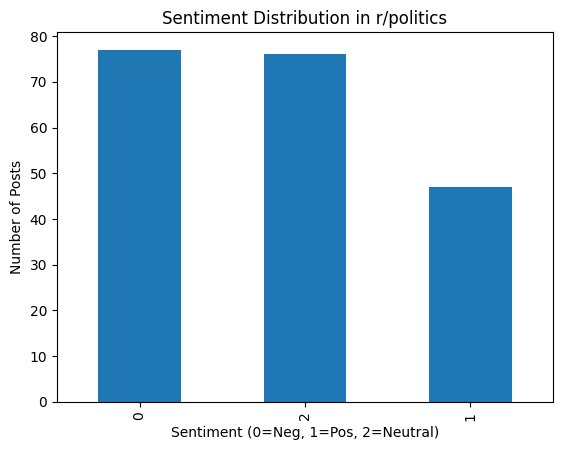

In [12]:
import matplotlib.pyplot as plt

sentiment_counts = df['sentiment'].value_counts()
sentiment_counts.plot(kind='bar')
plt.title("Sentiment Distribution in r/politics")
plt.xlabel("Sentiment (0=Neg, 1=Pos, 2=Neutral)")
plt.ylabel("Number of Posts")
plt.show()


In [14]:
posts = []
for submission in reddit.subreddit("politics").hot(limit=200):
    posts.append([
        submission.title,
        submission.selftext,
        submission.score,
        submission.num_comments,
        submission.created_utc   # <-- add timestamp
    ])

df = pd.DataFrame(posts, columns=["title", "body", "score", "num_comments", "created"])


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



In [15]:
df['created'] = pd.to_datetime(df['created'], unit='s')
df.head()


,title,body,score,num_comments,created
0,White House Melts Down Over Proof of Trump’s G...,,33967,1254,2025-09-08 23:47:52
1,Congress Reveals Epstein Birthday Note Trump S...,,39074,987,2025-09-08 19:54:15
2,Epstein Birthday Letter With Trump’s Signature...,,53595,2551,2025-09-08 18:51:54
3,Epstein 'Birthday Book' Depicts Shocking Joke ...,,4082,225,2025-09-09 01:23:34
4,Trump Says It’s Not His Signature. But Persona...,,4775,450,2025-09-08 23:59:11


In [17]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = analyzer.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return 1   # Positive
    elif score <= -0.05:
        return 0   # Negative
    else:
        return 2   # Neutral

df["sentiment"] = df["title"].apply(get_sentiment)
df.head()


,title,body,score,num_comments,created,sentiment
0,White House Melts Down Over Proof of Trump’s G...,,33967,1254,2025-09-08 23:47:52,0
1,Congress Reveals Epstein Birthday Note Trump S...,,39074,987,2025-09-08 19:54:15,2
2,Epstein Birthday Letter With Trump’s Signature...,,53595,2551,2025-09-08 18:51:54,2
3,Epstein 'Birthday Book' Depicts Shocking Joke ...,,4082,225,2025-09-09 01:23:34,0
4,Trump Says It’s Not His Signature. But Persona...,,4775,450,2025-09-08 23:59:11,2


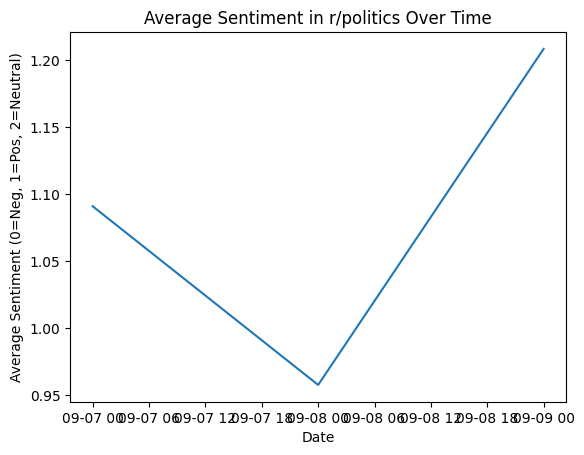

In [18]:
daily_sentiment = df.groupby(df['created'].dt.date)['sentiment'].mean()

import matplotlib.pyplot as plt
daily_sentiment.plot(kind='line')
plt.title("Average Sentiment in r/politics Over Time")
plt.xlabel("Date")
plt.ylabel("Average Sentiment (0=Neg, 1=Pos, 2=Neutral)")
plt.show()


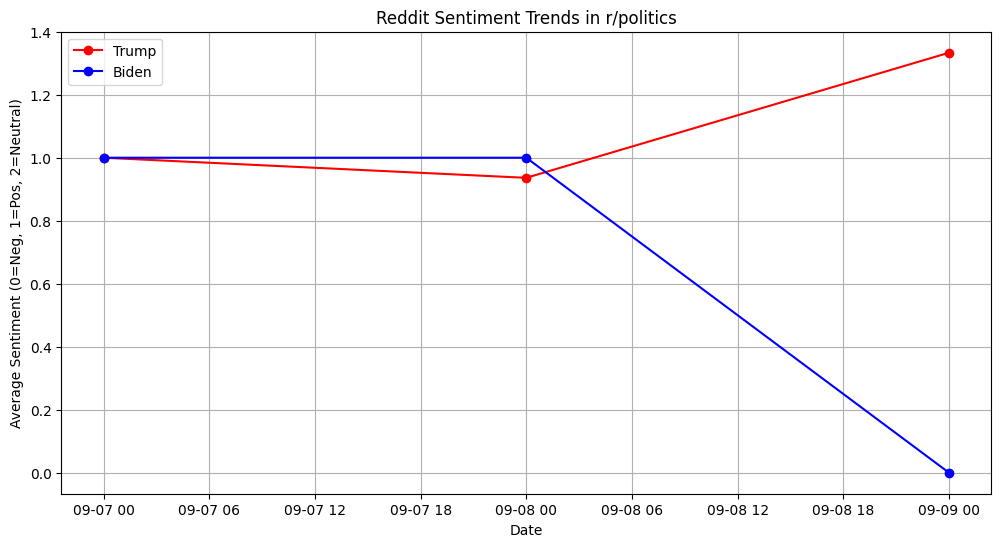

In [19]:
import matplotlib.pyplot as plt

# Separate Trump and Biden posts
df['trump'] = df['title'].str.contains("trump", case=False, na=False)
df['biden'] = df['title'].str.contains("biden", case=False, na=False)

# Daily average sentiment
trump_daily = df[df['trump']].groupby(df['created'].dt.date)['sentiment'].mean()
biden_daily = df[df['biden']].groupby(df['created'].dt.date)['sentiment'].mean()

# Plot
plt.figure(figsize=(12,6))
plt.plot(trump_daily.index, trump_daily.values, marker='o', linestyle='-', label="Trump", color="red")
plt.plot(biden_daily.index, biden_daily.values, marker='o', linestyle='-', label="Biden", color="blue")

plt.title("Reddit Sentiment Trends in r/politics")
plt.xlabel("Date")
plt.ylabel("Average Sentiment (0=Neg, 1=Pos, 2=Neutral)")
plt.legend()
plt.grid(True)
plt.show()
